In [39]:
import jax 
import jax.numpy as jnp
import matplotlib.pyplot as plt

from algebra.cliffordalgebra import CliffordAlgebra
from modules.conv.kernel import CliffordSteerableKernel
from modules.conv.convolution import CliffordSteerableConv

jax.config.update("jax_enable_x64", False)

RNG_ID = 42

In [40]:
TEST_EQUIVARIANCE = True

if TEST_EQUIVARIANCE:
    import torch
    from escnn import gspaces, group

# Visualizing kernels

### Euclidean space $\mathbb{R}^{(2,0)}$

Let us demonstrate an example with (p,q) = (2,0), which is equivalent to familiar two-dimensional Euclidean vector space.

The signature corresponds to the metric matrix with ones along the diagonal, i.e. diag((1,1)). It is the diagonal elements of the metrix matrix that we use to initialize the key object - Clifford algebra - which containts all necessary basic attributes and methods for our case (e.g. geometric product).

In [41]:
algebra = CliffordAlgebra((1,1))

/home/maxxxzdn/deusex/clifford-group-equivariant-cnns/.conda/lib/python3.11/site-packages/jax/_src/ops/scatter.py:96: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(


Let us now visualize a single Clifford-steerable kernel with c_in = c_out = 1. 

Since implicit kernels allow for arbitrary discretization, we use relatively high resolution. In practice, however, it will be much lower, e.g. 3x3, or 7x7x7.

In [42]:
resolution = 128

config = dict(
    algebra = algebra,
    kernel_size = resolution,
    c_in = 1,
    c_out = 1,
    num_layers = 4,
    hidden_dim = 12, 
    bias_dims = (0,),
    product_paths_sum = algebra.geometric_product_paths.sum().item()
)

In [43]:
kernel = CliffordSteerableKernel(**config)

# Initialize parameters
params = kernel.init(jax.random.PRNGKey(RNG_ID))

# Compute the kernel given the parameters
k = kernel.apply(params)

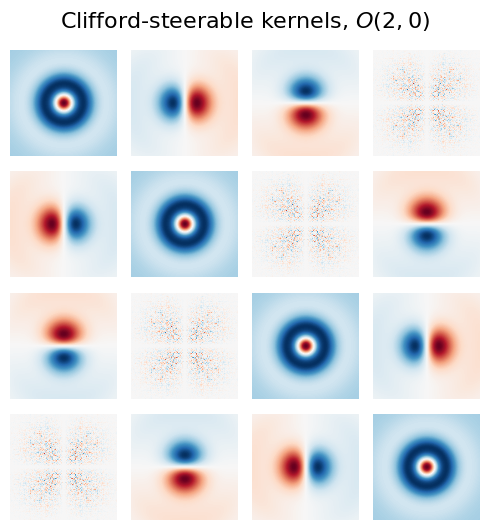

In [44]:
fig, ax = plt.subplots(4, 4, figsize=(5, 5))

for i in range(4):
    for j in range(4):
        ax[i, j].imshow(k[i, j].T, cmap='RdBu')
        ax[i, j].axis('off')
                
fig.tight_layout()

fig.suptitle('Clifford-steerable kernels, $O(2,0)$', fontsize=16, y=1.05)
plt.show()

Note that pseudoscalar kernel is not exactly zero, but it has negligible magnitute of order 1e-9.

### Minkowski space $\mathbb{R}^{(1,1)}$

In this case, there are negative elements along the diagonal of the metric tensor. 
Time-like dimensions are represented by positive elements in the metric tensor and space-like dimensions are represented by negative elements.

In [45]:
algebra = CliffordAlgebra((1,-1))

/home/maxxxzdn/deusex/clifford-group-equivariant-cnns/.conda/lib/python3.11/site-packages/jax/_src/ops/scatter.py:96: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(


In [46]:
resolution = 128

config = dict(
    algebra = algebra,
    kernel_size = resolution,
    c_in = 1,
    c_out = 1,
    num_layers = 4,
    hidden_dim = 12, 
    bias_dims = (0,),
    product_paths_sum = algebra.geometric_product_paths.sum().item()
)

In [47]:
kernel = CliffordSteerableKernel(**config)

# Initialize parameters
params = kernel.init(jax.random.PRNGKey(RNG_ID))

# Compute the kernel given the parameters
k = kernel.apply(params)

We now plot the kernel, y-axis corresponds to time, x-axis to space

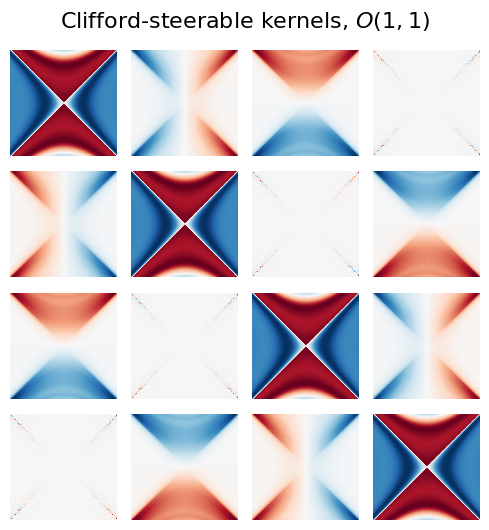

In [48]:
fig, ax = plt.subplots(4, 4, figsize=(5, 5))

for i in range(4):
    for j in range(4):
        ax[i, j].imshow(k[i, j].T, cmap='RdBu')
        ax[i, j].axis('off')
                
fig.tight_layout()

fig.suptitle('Clifford-steerable kernels, $O(1,1)$', fontsize=16, y=1.05)
plt.show()

# Applying convolution

Let us now initialize a convolutional layer and apply it to an input image.

In [49]:
algebra = CliffordAlgebra((1,1))

config = dict(
    algebra = algebra,
    c_in = 1,
    c_out = 1,
    kernel_size = 7,
    padding = True,
    num_layers = 4,
    hidden_dim = 12, 
    bias_dims = (0,),
    product_paths_sum = algebra.geometric_product_paths.sum().item()
)

/home/maxxxzdn/deusex/clifford-group-equivariant-cnns/.conda/lib/python3.11/site-packages/jax/_src/ops/scatter.py:96: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(


In [50]:
csconv = CliffordSteerableConv(**config)

# random input for initialization
mv = jax.random.normal(jax.random.PRNGKey(RNG_ID), (16,1,64,64,algebra.n_blades))
params = csconv.init(jax.random.PRNGKey(RNG_ID), mv)

Let us define our input multivector fields as follows:
- scalar: $sin(x) + cos(y)$ 
- vector: $\left[sin(x) sin(y), cos(x) cos(y)^2\right]$
- pseudoscalar: $cos(x) - sin(y)$


In [51]:
# Define the grid size
grid_size = 64

# Initialize the grid
x, y = jnp.meshgrid(jnp.linspace(0, 2 * jnp.pi, grid_size), jnp.linspace(0, 2 * jnp.pi, grid_size))

In [52]:
scalar = jnp.sin(x) + jnp.cos(y)
vector_x = jnp.sin(x) * jnp.sin(y)
vector_y = jnp.cos(x) + jnp.cos(y)**2
bivector = jnp.cos(x) - jnp.sin(y)

mv_field = jnp.stack([scalar, vector_x, vector_y, bivector], axis=-1)
mv_field = jnp.expand_dims(mv_field, axis=[0, 1])

In [53]:
# Apply the convolution
out = csconv.apply(params, mv_field)

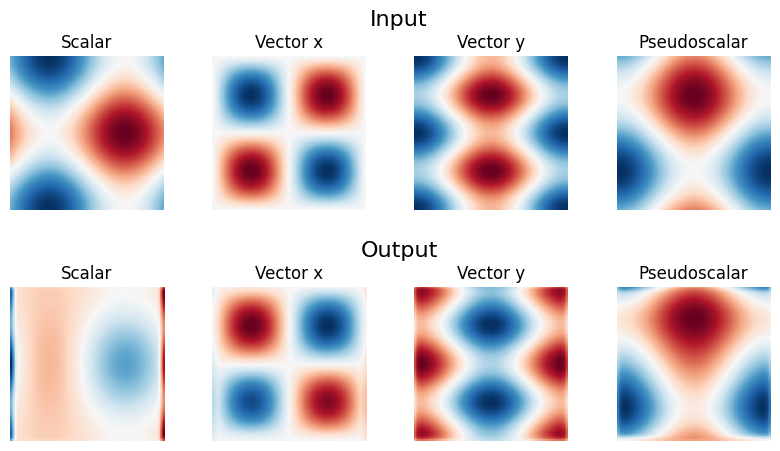

In [54]:
fig, ax = plt.subplots(2, 4, figsize=(10, 5))
component_names = ['Scalar', 'Vector x', 'Vector y', 'Pseudoscalar']
channel = 2

for i in range(4):
    ax[0,i].imshow(mv_field[0, channel, :, :, i], cmap='RdBu')
    ax[0,i].axis('off')
    ax[0,i].set_title(component_names[i])
    
for i in range(4):
    ax[1,i].imshow(out[0, channel, :, :, i], cmap='RdBu')
    ax[1,i].axis('off')
    ax[1,i].set_title(component_names[i])
    
# add space between the subplot rows
plt.subplots_adjust(hspace=0.5)
plt.text(-0.1, 1.2, 'Input', ha='center', fontsize=16, transform=ax[0,2].transAxes)
plt.text(-0.1, 1.2, 'Output', ha='center', fontsize=16, transform=ax[1,2].transAxes)
plt.show()

### Test equivariance

Let us first define how separate components of the multivector field transform under rotations.

We test for O(2) group, which corresponds to gspaces.flipRot2dOnR2(-1) in escnn.

In [75]:
gspace = gspaces.flipRot2dOnR2(4)
scalar, pseudoscalar, vector = gspace.fibergroup.irreps()[:3] # multivector grades 0, 1, 2
representation = group.directsum([scalar, vector, pseudoscalar]) # multivector representation is a direct sum of the irreps
mv_type = gspace.type(*[representation]) # this is the type of the field in the language of escnn

Next, lets define necessary machinery to translate from jax to escnn (pytorch) and back.

In [76]:
def to_geometric_tensor_torched(mv, ftype):
    """
    Converts a multivector jnp array to a torch tensor and defines the corresponding escnn' geometric tensor.
    
    Args:
        mv: jnp.array of shape (batch, channel, height, width, algebra.n_subspaces).
        ftype: escnn.FieldType, the type of the field.
    
    Returns:
        mv: escnn.GeometricTensor with tensor of shape (batch, channel*algebra.n_subspaces, height, width) and type ftype.
    """
    mv = torch.tensor(mv.__array__(), dtype=torch.float32)
    mv = mv.permute(0,1,-1,2,3)
    mv = mv.reshape(mv.shape[0], -1, mv.shape[-2], mv.shape[-1])
    mv = mv_type(mv)
    return mv

def to_mv_jaxed(mv):
    """
    Converts a torch tensor to a multivector jnp array.
    
    Args:
        mv: escnn.GeometricTensor with tensor of shape (batch, channel*algebra.n_subspaces, height, width) and type ftype.
        
    Returns:
        mv: jnp.array of shape (batch, channel, height, width, algebra.n_subspaces).
    """
    mv = mv.tensor
    mv = mv.reshape(mv.shape[0], -1, 4, mv.shape[-2], mv.shape[-1])
    mv = mv.permute(0,1,3,4,2)
    mv = jnp.array(mv.numpy(), dtype=jnp.float32)
    return mv

We now convert our multivector array to a geometric tensor with the corresponding field type.

In [77]:
mv_gt = to_geometric_tensor_torched(mv_field, mv_type)

Let's pick a random group element (reflection + rotation) and apply it to the input multivector field.

In [81]:
g = list(gspace.testing_elements)[1]
mv_gt_transformed = mv_gt.transform(g)

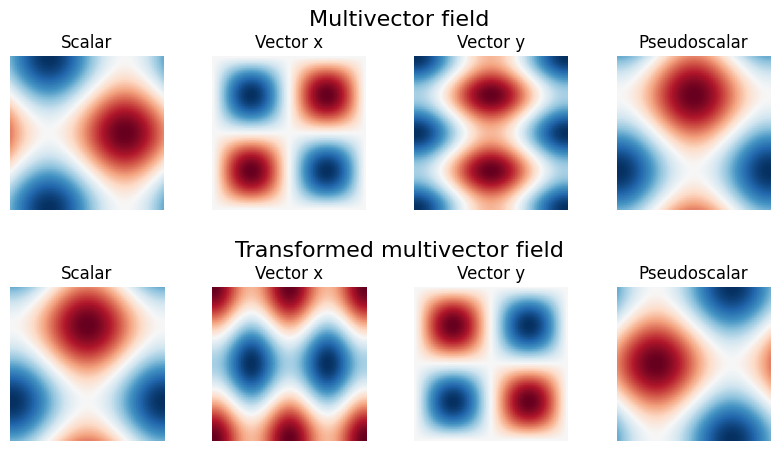

In [82]:
fig, ax = plt.subplots(2, 4, figsize=(10, 5))
component_names = ['Scalar', 'Vector x', 'Vector y', 'Pseudoscalar']
channel = i

for i in range(4):
    ax[0,i].imshow(mv_gt.tensor[0, i, :, :], cmap='RdBu')
    ax[0,i].axis('off')
    ax[0,i].set_title(component_names[i])
    
for i in range(4):
    ax[1,i].imshow(mv_gt_transformed.tensor[0, i, :, :], cmap='RdBu')
    ax[1,i].axis('off')
    ax[1,i].set_title(component_names[i])
    
# add space between the subplot rows
plt.subplots_adjust(hspace=0.5)
plt.text(-0.1, 1.2, 'Multivector field', ha='center', fontsize=16, transform=ax[0,2].transAxes)
plt.text(-0.1, 1.2, 'Transformed multivector field', ha='center', fontsize=16, transform=ax[1,2].transAxes)
plt.show()

Let's now do the equivariance check. We want to assure that the transformation and the convolution commute. 

We will do this by comparing $T(\mathcal{C}(x))$ with $\mathcal{C}(T(x))$, where $T$ is the transformation and $C$ is convolution.

In [83]:
# 1) rotation -> 2) rotation
out_rotated_conv = to_geometric_tensor_torched(csconv.apply(params, to_mv_jaxed(mv_gt_transformed)), mv_type)

# 1) convolution -> 2) rotation
out_conv_rotated = to_geometric_tensor_torched(out, mv_type).transform(g)

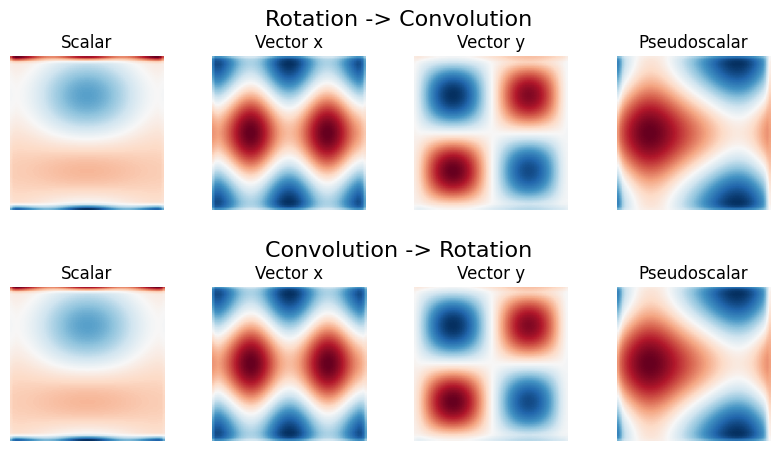

In [87]:
fig, ax = plt.subplots(2, 4, figsize=(10, 5))
component_names = ['Scalar', 'Vector x', 'Vector y', 'Pseudoscalar']
channel = i

for i in range(4):
    ax[0,i].imshow(out_rotated_conv.tensor[0, i, :, :], cmap='RdBu')
    ax[0,i].axis('off')
    ax[0,i].set_title(component_names[i])
    
for i in range(4):
    ax[1,i].imshow(out_conv_rotated.tensor[0, i, :, :], cmap='RdBu')
    ax[1,i].axis('off')
    ax[1,i].set_title(component_names[i])
    
# add space between the subplot rows
plt.subplots_adjust(hspace=0.5)
plt.text(-0.1, 1.2, 'Rotation -> Convolution', ha='center', fontsize=16, transform=ax[0,2].transAxes) 
plt.text(-0.1, 1.2, 'Convolution -> Rotation', ha='center', fontsize=16, transform=ax[1,2].transAxes)
plt.show()

In [108]:
# Compute relative error
relative_error = torch.abs(out_rotated_conv.tensor - out_conv_rotated.tensor) / torch.abs(out_rotated_conv.tensor + out_conv_rotated.tensor)

# display up to 5 decimal places
print(f"Relative error (mean): {relative_error.mean().item():.1e}")
print(f"Relative error (max): {relative_error.max().item():.1e}")

Relative error (mean): 2.1e-07
Relative error (max): 1.2e-04
